In [89]:
import copick
import os
import json
import zarr
import numpy as np
import matplotlib.pyplot as plt

def get_root(cnfg_path="copick_config.json"):
    root = copick.from_file("copick_config.json")
    return root

def get_picks_dict(root, particles_only=True):
    pick_dict = {}
    for pick in root.pickable_objects:
        pick_dict[pick.name] = {
            'is_particle': pick.is_particle,
            'label': pick.label,
            'color': pick.color,
            'pdb_id': pick.pdb_id,
            'radius': pick.radius,
            'threshold': pick.map_threshold
        }
    if particles_only:
        return {k : v for k, v in pick_dict.items() if v.get('is_particle')}
    return pick_dict

In [90]:
# Function to load CryoET OME-Zarr data at all resolutions
def get_run_volume_picks(root, run='TS_5_4', level=0, particles=None):
    
    zarr_path = os.path.join(root.root_static, f"ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr")
    picks_path = os.path.join(root.root_overlay, f"ExperimentRuns/{run}/Picks")
    
    if particles is None: 
        pick_dict = get_picks_dict(root)
        particles = [k for k, v in pick_dict.items() if v.get('is_particle')]

    # Open the OME-Zarr dataset
    store = zarr.DirectoryStore(zarr_path)
    zarrs = zarr.open(store, mode='r')
    
    level_info = zarrs.attrs['multiscales'][0]['datasets'][level]
    
    scales = np.array(level_info['coordinateTransformations'][0]['scale'])
    
    # Swap scales since data has x & z switched
    scales[[0, 2]] = scales[[2, 0]]
    
    path = level_info["path"]
    
    volume = np.array(zarrs[path][:])
    
    # Load ground truth JSONs (particle coordinates)
    particle_coords = {}
    for particle in particles:
        json_path = os.path.join(picks_path, f"{particle}.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                # Get json file
                json_data = json.load(f)
                pick_data = json_data['points']
                
                # Get all picks for specific particle type
                picks = []
                for pick in pick_data:
                    coords = pick['location']
                    # Swap the x and z coords since data has them swapped
                    picks.append(np.array([coords['z'], coords['y'],  coords['x']]) / scales)
                particle_coords[particle] = np.array(picks)
                
                    
        else:
            print(f"Ground truth file for {particle} not found.")
    
    return volume, particle_coords, scales

In [91]:
import numpy as np

def create_sphere(volume, center, radius, value=1):
    """
    Creates a sphere in a 3D volume array.

    Parameters:
    volume: 3D numpy array
    center: (x, y, z) coordinates of the sphere's center
    radius: radius of the sphere
    value: value to assign to the sphere's voxels

    Returns:
    3D numpy array with the sphere
    """

    x, y, z = np.ogrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]]
    dist_sq = (x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2
    volume[dist_sq <= radius ** 2] = value
    return volume

# i = 8

# volume = np.zeros((16,16,16))
# print(volume[i])

# volume = create_sphere(volume, (7,7,7), 7)

# print(volume[i])

In [92]:
def get_picks_mask(shape, pick_dict, coords, scale):
    mask = np.zeros(shape)
    
    for particle in pick_dict:
        print(pick_dict[particle]['radius'])
        rad = int(np.ceil(pick_dict[particle]['radius'] / scale))
        
        val = pick_dict[particle]['label']
        points = coords[particle]
        for idx in range(points.shape[0]):
            point = points[idx]
            mask = create_sphere(mask, point, rad, val)
    
    return mask




In [93]:
# {"x": 468.514, "y": 5915.906, "z": 604.167}
root = get_root()

picks = get_picks_dict(root)

vol, coords, scales = get_run_volume_picks(root, level=2)

for pick in picks:
    print(pick)

apo-ferritin
beta-amylase
beta-galactosidase
ribosome
thyroglobulin
virus-like-particle


In [94]:
mask = get_picks_mask(vol.shape, picks, coords, int(scales[0]))


60.0
65.0
90.0
150.0
130.0
135.0


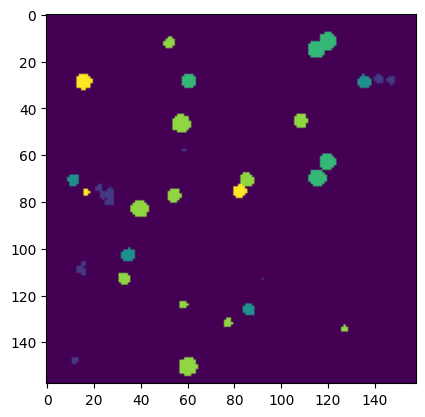

In [96]:
plt.imshow(mask[14, :, :], cmap="viridis")